In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt

MODELS= ['A_T1', 'A_T2', 'AT_3']
#Shift = 44 means (aprox) a minute after and before
SHIFT= 44
RATIO= 85.0/65.0
ds= {}

#Load data
raw_dataset= pd.read_csv('AtoData.csv', na_values='?')
raw_dataset.pop('A')

#Preprocess data
for m in MODELS:
    ds1= raw_dataset.copy()
    ds1= ds1.drop(ds1[ds1['model'] != m].index)
    ds1.pop('model')
    ds1['Ti']= ds1['T'].shift(SHIFT)
    ds1['min']= ds1["min"].rolling(window=SHIFT, min_periods=1).sum()
    ds1= ds1.dropna()
    ds2= raw_dataset.copy()
    ds2= ds2.drop(ds2[ds2['model'] != m].index)
    ds2.pop('model')
    ds2['Ti']= ds2['T'].shift(-SHIFT)
    ds2['min']= ds2["min"].rolling(window=SHIFT, min_periods=1).sum().shift(-SHIFT)
    ds2= ds2.dropna()
    ds[m]= pd.concat([ds1, ds2])
ds_t= pd.concat(ds)
ds_t['Ti']= ds_t['Ti'] * RATIO
ds_t['T']= ds_t['T'] * RATIO
ds_t['warm'] = (ds_t['Ti'] < ds_t['T'])*1.0
ds_t['cold'] = (ds_t['Ti'] > ds_t['T'])*1.0
print(ds_t.count())

min     7030
T       7030
Ti      7030
warm    7030
cold    7030
dtype: int64


In [51]:
#Split tran and test sets
train= ds_t.sample(frac=0.8, random_state=0)
test= ds_t.drop(train.index)

#Get data stats
train_stats = train.describe()
train_stats.pop('T')
train_stats = train_stats.transpose()
print(train_stats)

       count       mean        std        min        25%        50%  \
min   5624.0   1.069273   0.106324   1.010000   1.020000   1.030000   
Ti    5624.0  70.070907  15.944285  32.326154  58.427692  75.414615   
warm  5624.0   0.501600   0.500042   0.000000   0.000000   1.000000   
cold  5624.0   0.498400   0.500042   0.000000   0.000000   0.000000   

            75%        max  
min    1.050000   1.520000  
Ti    84.123846  88.386923  
warm   1.000000   1.000000  
cold   1.000000   1.000000  


In [52]:
#Constants from the dataset to normalize
MEAN_TEMP= 70.070907
MEAN_TIME= 1.069273
STD_TEMP= 15.944285
STD_TIME= 0.106324

#Pop the output from the dataset
train_labels = train.pop('T')
test_labels = test.pop('T')

#Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

#Build model
def build_model():
  model = keras.Sequential([
    layers.Dense(250, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(250, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  
  return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Run the model
EPOCHS = 1000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

c:\Users\Josè Castillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
32,1.285703,0.900470,1.285703,1.703912,0.998780,1.703912,32
33,1.240286,0.888543,1.240286,1.999334,1.283559,1.999334,33
34,1.284674,0.885601,1.284674,0.454596,0.503936,0.454596,34
35,1.185552,0.833434,1.185552,3.340484,1.647397,3.340484,35
36,1.261285,0.884154,1.261285,0.610288,0.601915,0.610288,36


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


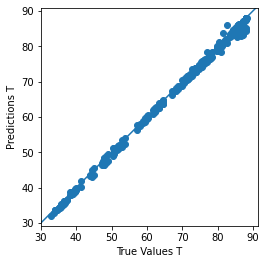

In [53]:
#Test the model
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values T')
plt.ylabel('Predictions T')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])

In [54]:
# model.save('AtoModel.keras')

In [57]:
print(normed_test_data)

                min        Ti      warm      cold
A_T1 2519 -0.369367 -2.341045  0.996716 -0.996716
     2544 -0.275316 -2.194236  0.996716 -0.996716
     2547 -0.557471 -2.180293  0.996716 -0.996716
     2582 -0.369367 -2.024462  0.996716 -0.996716
     2613 -0.275316 -1.868631  0.996716 -0.996716
...             ...       ...       ...       ...
AT_3 6033 -0.463419  1.002762 -1.003117  1.003117
     6036 -0.557471  1.002762 -1.003117  1.003117
     6041 -0.463419  1.004402 -1.003117  1.003117
     6057 -0.369367  1.007683 -1.003117  1.003117
     6075 -0.369367  1.011784 -1.003117  1.003117

[338 rows x 4 columns]
